## **Data Load**

In [17]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import timeit
import tracemalloc
import seaborn as sns
import random
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
mat_content = sio.loadmat('assets/face.mat')
# mat_content # Let's see the content...

face_data = mat_content['X']
face_labels = mat_content['l']

x_train, x_test, y_train, y_test = [], [], [], []

n_classes = 52
images_per_class = 10

for i in range(n_classes):
    start_idx = i * images_per_class
    end_idx = start_idx + images_per_class

    x_train.append(face_data[:, start_idx:start_idx+8])
    x_test.append(face_data[:, start_idx+8:end_idx])

    y_train.append(face_labels[:, start_idx:start_idx+8])
    y_test.append(face_labels[:, start_idx+8:end_idx])

x_train, x_test = np.hstack(x_train), np.hstack(x_test)
y_train, y_test = np.hstack(y_train), np.hstack(y_test)

x_train = x_train.astype(np.int64)
x_test = x_test.astype(np.int64)

# Output the shapes of the training and testing sets
print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")

Training set shape: (2576, 416)
Test set shape: (2576, 104)


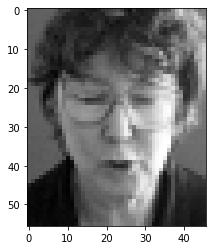

In [3]:
# show one example image
plt.imshow(np.reshape(x_train[:,0],(46,56)).T, cmap = 'gist_gray')

### **Additional Functions**

In [18]:
def draw_confusion_matrix(y_test, y_pred):
    # confusion matrix with 5 base eigenvectors
    cm = confusion_matrix(y_test.reshape(-1), y_pred)

    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix of RF')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [90]:
def print_results(accuracy, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth):
    print(f"Training Memory Usage (Peak): {train_peak_memory / 10**6:.3f} MB")
    print(f"Training Execution Time: {train_time:.8f} seconds")
    print('\n')

    print(f"Test Memory Usage (Peak): {test_peak_memory / 10**6:.3f} MB")
    print(f"Test Execution Time: {test_time:.8f} seconds")
    print('\n')

    print(f"Maximum depth of trees in the forest: {max_tree_depth}")

    print(f"Accuracy: {accuracy * 100:.2f}%")

In [119]:
def get_suc_fail_cases(y_test, y_pred):
    # Separate success and failure cases
    suc_idx = []
    suc_label = []
    fail_idx = []
    fail_case_prediction_label = []
    fail_case_true_label = []

    for i in range(len(y_pred)):
        if y_test.T[i] == y_pred[i]:
            suc_idx.append(i)
            suc_label.append(y_test.T[i])
        else:
            fail_idx.append(i)
            # fail as which image
            fail_case_prediction_label.append(y_pred.T[i])
            fail_case_true_label.append(y_test.T[i])

    return suc_idx, suc_label, fail_idx, fail_case_prediction_label, fail_case_true_label

In [52]:
def RF_classification(x_train, y_train, x_test, y_test, n_estimators=100, max_depth=1000, bootstrap=True, random_state=0, max_samples=0.8, max_features="sqrt", criterion='entropy', time_memory_check=False):
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, bootstrap=bootstrap, random_state=random_state, max_samples=max_samples, max_features=max_features, criterion=criterion)

    # Train ----------------------------------------------------------
    tracemalloc.start() 
    start_time = timeit.default_timer() 
    
    rf_clf.fit(x_train.T, y_train.ravel())
    
    train_time = timeit.default_timer() - start_time
    current, train_peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Test ----------------------------------------------------------
    tracemalloc.start() 
    start_time = timeit.default_timer()

    y_pred = rf_clf.predict(x_test.T)

    test_time = timeit.default_timer()- start_time
    current, test_peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    accuracy = accuracy_score(y_test.T, y_pred)

    # Full classification report
    # print(classification_report(y_test.T, y_pred, zero_division=0))

    # Retrieve the maximum depth of each tree in the forest
    tree_depths = [estimator.tree_.max_depth for estimator in rf_clf.estimators_]
    max_tree_depth = max(tree_depths)

    return accuracy, y_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth

In [50]:
def create_two_pixel_features(x_train, x_test, n_pairs=None, random_seed=None):
    x_combined = np.concatenate([x_train, x_test], axis=1)

    n_features, n_samples = x_combined.shape

    # Set random seed if provided
    if random_seed is not None:
        random.seed(random_seed)

    # Generate all unique pairs of features where i != j
    feature_pairs = [(i, j) for i in range(n_features) for j in range(i + 1, n_features)]

    # If n_pairs is specified, randomly select a subset of feature pairs
    if n_pairs is not None and n_pairs < len(feature_pairs):
        feature_pairs = random.sample(feature_pairs, n_pairs)
    
    # Initialize a new features matrix for pairwise differences
    new_features = np.zeros((len(feature_pairs), n_samples))

    # Fill in the new features with pairwise differences
    for idx, (i, j) in enumerate(feature_pairs):
        new_features[idx, :] = x_combined[i, :] - x_combined[j, :]

    x_train_2pix = new_features[:, :x_train.shape[1]]
    x_test_2pix = new_features[:, x_train.shape[1]:]

    return x_train_2pix, x_test_2pix

In [84]:
def avg_results(num_iter, x_train, y_train, x_test, y_test, n_estimators=5, max_depth=15, bootstrap=True, random_state=0, max_samples=0.7, max_features="sqrt", criterion='entropy'):
    results_array = np.zeros((6,))
    
    for i in range(num_iter):
        accuracy, y_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth = RF_classification(x_train, y_train, x_test, y_test, n_estimators=n_estimators, max_depth=max_depth, bootstrap=bootstrap, random_state=random_state, max_samples=max_samples, max_features=max_features, criterion=criterion)
        results_array += np.array([accuracy, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth])

    results_array /= num_iter
    return results_array

## **Q5. RF classifier**

Weak learner: Axis-aligend test

Training Memory Usage (Peak): 4.42107 MB
Training Execution Time: 0.16371375 seconds


Test Memory Usage (Peak): 1.210016 MB
Test Execution Time: 0.00215104 seconds


Maximum depth of trees in the forest: 9
Accuracy: 33.65%


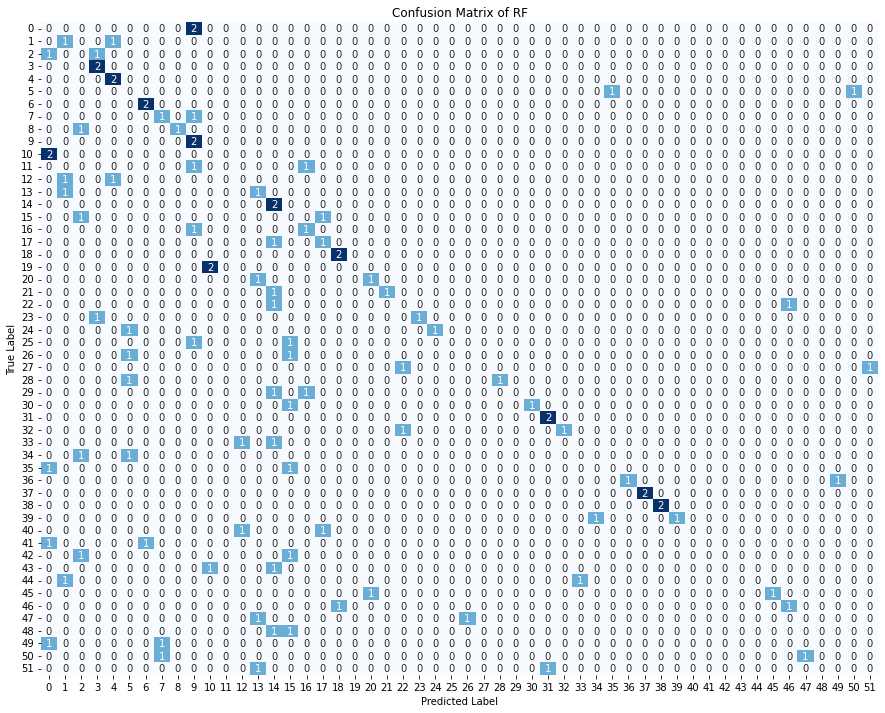

In [85]:
# Get results
accuracy, y_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth = RF_classification(x_train, y_train, x_test, y_test, n_estimators=5, max_depth=15, bootstrap=True, random_state=0, max_samples=0.7, max_features="sqrt", criterion='entropy', time_memory_check=True)

# Print results
print_results(accuracy, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth)

# Draw confusion matrix
draw_confusion_matrix(y_test, y_pred)

# Get success and failure examples
suc_idx, suc_label, fail_idx, fail_case_prediction_label, fail_case_true_label = get_suc_fail_cases(y_test, y_pred)

Weak learner: Two-Pixel Test

In [130]:
len(fail_case_true_label)

27

In [129]:
len(suc_label)

77

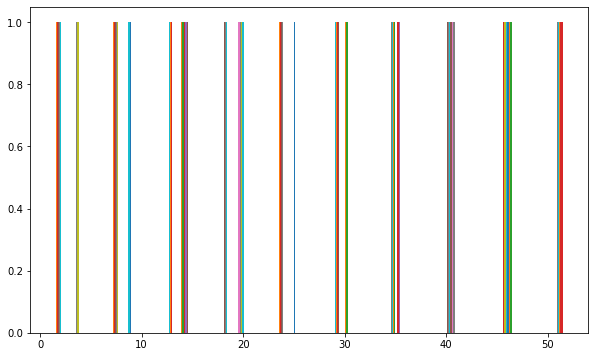

In [128]:
# Define the number of bins (you can adjust as needed)
bins = 52

# Plotting the histograms
plt.figure(figsize=(10, 6))
# plt.hist(suc_label, bins=bins, alpha=0.5, label='Success')
plt.hist(suc_label, label='Success')
plt.hist(fail_case_true_label, label='Failure')
# plt.hist(fail_case_true_label, bins=bins, alpha=0.5, label='Failure')

# Adding labels and title

plt.show()

Training Memory Usage (Peak): 166.533 MB
Training Execution Time: 5.25649079 seconds


Test Memory Usage (Peak): 41.743 MB
Test Execution Time: 0.02301579 seconds


Maximum depth of trees in the forest: 9
Accuracy: 74.04%


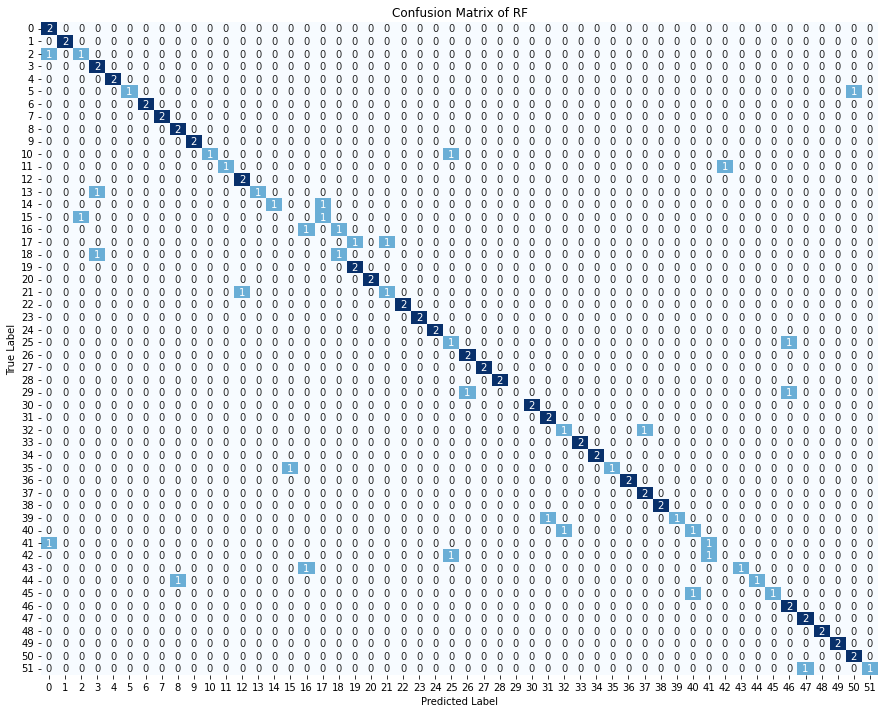

In [120]:
x_train_2pix, x_test_2pix = create_two_pixel_features(x_train, x_test, n_pairs=100000, random_seed=0)

# Get results
accuracy, y_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth = RF_classification(x_train_2pix, y_train, x_test_2pix, y_test, n_estimators=30, max_depth=15, bootstrap=True, random_state=0, max_samples=0.7, max_features="sqrt", criterion='entropy', time_memory_check=True)

# Print results
print_results(accuracy, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth)

# Draw confusion matrix
draw_confusion_matrix(y_test, y_pred)

# Get success and failure examples
suc_idx, suc_label, fail_idx, fail_case_prediction_label, fail_case_true_label = get_suc_fail_cases(y_test, y_pred)

Average result

In [91]:
# average result of two-pixel test
num_iter = 10

results_array = avg_results(num_iter, x_train, y_train, x_test, y_test, n_estimators=5, max_depth=15, bootstrap=True, random_state=0, max_samples=0.7, max_features="sqrt", criterion='entropy')

print(f'average results with {num_iter} iterations')
print_results(results_array[0], results_array[1], results_array[2], results_array[3], results_array[4], results_array[5])

average results with 10 iterations
Training Memory Usage (Peak): 4.419 MB
Training Execution Time: 0.16428766 seconds


Test Memory Usage (Peak): 1.212 MB
Test Execution Time: 0.00219765 seconds


Maximum depth of trees in the forest: 9.0
Accuracy: 33.65%


Hyperparameter Tunign

In [107]:
# Hyperparameter tuning
def RF_random_search(x_train, y_train, x_test, y_test, n_iter, cv, random_state=None):
    # Search settings
    rf_clf = RandomForestClassifier(n_estimators=50, bootstrap=True, random_state=random_state)

    param_distributions = dict()
    # param_distributions['n_estimators'] = [10*i for i in range(1, 11)]
    # param_distributions['max_depth'] = [i for i in range(5,21)]
    # param_distributions['max_samples'] = [0.1 * i for i in range(1,11)]
    param_distributions['max_features'] = ['sqrt', 'log2', None]
    # param_distributions['criterion'] = ["gini", "entropy"]
    
    random_search = RandomizedSearchCV(rf_clf, param_distributions, n_iter=n_iter, scoring='accuracy', cv=cv, n_jobs=-1)
    random_result = random_search.fit(x_train.T, y_train.ravel())

    print(f'Best Parameters: {random_search.best_params_}')
    print(f'Best Accuracy: {random_result.best_score_}')

    best_rf = random_search.best_estimator_

    y_pred = best_rf.predict(x_test.T)
    accuracy = accuracy_score(y_test.T, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    return random_search.best_estimator_

best_rf = RF_random_search(x_train, y_train, x_test, y_test, n_iter=3, cv=5, random_state=0)

KeyboardInterrupt: 